In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, col, lit, array_contains

# Spark başlat
spark = SparkSession.builder.appName("JSON_to_CSV_with_Lists").getOrCreate()

# JSON dosyalarını oku
file_paths = [f"../../../tt_data/capstone.{i}.jsonl" for i in range(1, 11)]
df = spark.read.json(file_paths)

# Uygulama listesi
app_list = ['İzleGo', 'RitimGo', 'CüzdanX', 'HızlıPazar', 'Konuşalım']

# Her uygulama için yeni sütun oluştur
for app in app_list:
    df = df.withColumn(app, when(array_contains(col("apps"), app), lit(1)).otherwise(lit(0)))

# Gereksiz sütunu (listeyi) kaldır
df = df.drop("apps")

# Sonuçları göster (kontrol amaçlı)
df.show(truncate=False)


In [ ]:
# Parquet olarak kaydetme (tek dosya olarak kaydeder)
parquet_output_path = "../../../tt_data/capstone_with_apps.parquet"
df.write.mode("overwrite").parquet(parquet_output_path)

print("Parquet formatında başarıyla kaydedildi.")


In [ ]:
from pyspark.sql import SparkSession  # Spark oturumu için gerekli

# Spark oturumunu başlat
spark = SparkSession.builder.appName("Parquet_Read_Write").getOrCreate()

# Parquet dosyasının yolu
parquet_output_path = "../../../tt_data/capstone_with_apps.parquet"

# **Parquet dosyasını oku**
df_parquet = spark.read.parquet(parquet_output_path)

# **Satır sayısını kontrol et**
print("Parquet Dosyasından Okunan Toplam Satır Sayısı:", df_parquet.count())

# **İlk birkaç satırı göster**
df_parquet.show(truncate=False)


In [ ]:
from pyspark.sql.functions import when, col

# **1️⃣ Tüm Unique Değerleri Çıkart**
auto_payment_categories = [row[0] for row in df_parquet.select("auto_payment").distinct().collect()]
service_type_categories = [row[0] for row in df_parquet.select("service_type").distinct().collect()]

# **2️⃣ Her Unique Değer İçin Yeni Kolon Aç ve 1/0 Ata**
for category in auto_payment_categories:
    df_parquet = df_parquet.withColumn(f"auto_payment_{category}", when(col("auto_payment") == category, 1).otherwise(0))

for category in service_type_categories:
    df_parquet = df_parquet.withColumn(f"service_type_{category}", when(col("service_type") == category, 1).otherwise(0))

# **3️⃣ Orijinal Kolonları Kaldır (Opsiyonel)**
df_parquet = df_parquet.drop("auto_payment", "service_type")

# **4️⃣ Sonucu Göster**
df_parquet.show(truncate=False)


In [ ]:
df_parquet.describe()


In [ ]:
from pyspark.sql.functions import col, sum

# **1️⃣ Churn = 1 olan satırları filtrele**
df_churn = df_parquet.filter(col("churn") == 1)

# **2️⃣ Churn=1 olan toplam satır sayısını hesapla**
total_churn_count = df_churn.count()

# **3️⃣ Her kolonun churn=1 olan satırlarda 1 olma yüzdesini hesapla**
columns_to_check = ["İzleGo", "RitimGo", "CüzdanX", "HızlıPazar", "Konuşalım",
                    "auto_payment_True", "auto_payment_False", "auto_payment_None",
                    "service_type_Prepaid", "service_type_Broadband", "service_type_Postpaid"]

percentages = {}
for col_name in columns_to_check:
    count_with_1 = df_churn.filter(col(col_name) == 1).count()  # Churn=1'de bu değişkenin 1 olduğu satır sayısı
    percentage = (count_with_1 / total_churn_count) * 100 if total_churn_count > 0 else 0
    percentages[col_name] = percentage

# **4️⃣ Sonuçları yazdır**
for col_name, percentage in percentages.items():
    print(f"{col_name} sütunu, churn=1 olan satırların %{percentage:.2f}’sinde 1 değerini alıyor.")


In [ ]:
from pyspark.sql.functions import col, sum

# Her sütundaki None (null) değer sayısını hesapla
null_counts = df_parquet.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_parquet.columns])

# Sonuçları ekrana yazdır
null_counts.show(truncate=False)


In [ ]:
print(df_parquet.columns)


In [ ]:
df_parquet.show(truncate=False)


In [ ]:
from pyspark.sql.functions import col, sum

# **1️⃣ Kontrol edilecek sütunları tanımla**
categorical_columns = [
    "auto_payment_True", "auto_payment_False", "auto_payment_None",
    "service_type_Prepaid", "service_type_Broadband", "service_type_Postpaid"
]

numeric_columns = ["avg_call_duration", "call_drops", "data_usage", "monthly_charge", "roaming_usage"]

# **2️⃣ Kategorik değişkenlere göre her sayısal sütunun eksik olup olmadığını say**
for cat_col in categorical_columns:
    print(f"✅ {cat_col} sütununun 1 ve 0 olduğu durumlara göre eksik veri analizi:")
    
    df_parquet.groupBy(cat_col).agg(
        *[sum(col(num_col).isNull().cast("int")).alias(f"{num_col}_None_Count") for num_col in numeric_columns]
    ).show(truncate=False)


In [ ]:
# **1️⃣ Parquet çıkış yollarını tanımla**
prepaid_output_path = "../../../tt_data/service_type_Prepaid.parquet"
postpaid_output_path = "../../../tt_data/service_type_Postpaid.parquet"
broadband_output_path = "../../../tt_data/service_type_Broadband.parquet"

# **2️⃣ Filtreleme ve Kaydetme İşlemleri**
df_parquet.filter(col("service_type_Prepaid") == 1).write.mode("overwrite").parquet(prepaid_output_path)
print("✅ service_type_Prepaid olanlar kaydedildi.")

df_parquet.filter(col("service_type_Postpaid") == 1).write.mode("overwrite").parquet(postpaid_output_path)
print("✅ service_type_Postpaid olanlar kaydedildi.")

df_parquet.filter(col("service_type_Broadband") == 1).write.mode("overwrite").parquet(broadband_output_path)
print("✅ service_type_Broadband olanlar kaydedildi.")

df_parquet.filter(col("service_type_Postpaid") == 1).select("auto_payment_True", "auto_payment_False","auto_payment_None").show(20)


# Prepaid Parquet

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# **1️⃣ Spark Oturumunu Başlat**
spark = SparkSession.builder.appName("auto_payment").getOrCreate()

# **2️⃣ Parquet Dosyasını Oku**
prepaid_parquet_path = "../../../tt_data/service_type_Prepaid.parquet"
df_prepaid = spark.read.parquet(prepaid_parquet_path)

# **3️⃣ Gereksiz `auto_payment` sütunlarını kaldır**
df_prepaid = df_prepaid.drop("auto_payment_True", "auto_payment_False", "auto_payment_None")

# **4️⃣ Güncellenmiş Sütunları Göster**
print("✅ Güncellenmiş sütunlar:", df_prepaid.columns)

# **5️⃣ İlk 10 Satırı Göster**
df_prepaid.show(10)


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, when

# **1️⃣ Spark oturumunu başlat**
spark = SparkSession.builder.appName("MissingDataAnalysis").getOrCreate()

# **2️⃣ Parquet Dosyasını Oku**
df = spark.read.parquet("../../../tt_data/service_type_Prepaid.parquet")

# **3️⃣ Sayısal ve Kategorik Değişkenleri Tanımla**
numeric_columns = ["avg_call_duration", "data_usage", "monthly_charge", "tenure"]
categorical_columns = [
    "İzleGo", "RitimGo", "CüzdanX", "HızlıPazar", "Konuşalım",
]

# **4️⃣ Sayısal değişkenlerden herhangi biri None ise 1 olarak işaretleyelim**
df = df.withColumn(
    "is_missing",
    when(
        col("avg_call_duration").isNull() | 
        col("data_usage").isNull() | 
        col("monthly_charge").isNull() | 
        col("tenure").isNull(), 1
    ).otherwise(0)
)

# **5️⃣ Kategorik değişkenlere göre None olan satırları gruplama**
for cat_col in categorical_columns:
    print(f"✅ {cat_col} sütununun 1 ve 0 olduğu durumlara göre eksik veri analizi:")
    
    df.groupBy(cat_col).agg(
        sum(col("is_missing")).alias("Missing_Count"),
        sum(col("is_missing")).cast("float") / df.count() * 100
    ).show(truncate=False)


In [ ]:
df.describe().show()

In [ ]:
from pyspark.sql.functions import col

# **1️⃣ Medyanı hesaplamak için fonksiyon yazalım**
def get_median(df, column_name):
    median_value = df.approxQuantile(column_name, [0.5], 0.01)[0]  # 0.5 = Medyan
    return median_value

# **2️⃣ Eksik verileri dolduracağımız sütunları belirleyelim**
columns_to_impute = ["avg_call_duration", "data_usage", "monthly_charge", "tenure"]

# **3️⃣ Her sütun için medyan hesapla ve None olanları doldur**
impute_values = {col: get_median(df, col) for col in columns_to_impute}  # Sütunlara göre medyanları hesapla

df = df.fillna(impute_values)  # None değerleri medyan ile doldur

# **4️⃣ Sonucu göster**
df.select(columns_to_impute).describe().show()
print("✅ Eksik değerler medyan ile dolduruldu.")


In [ ]:
df.describe().show()

In [ ]:
from pyspark.sql.functions import col, sum

# **1️⃣ Yeni Sütun: `total_apps_used` Hesapla**
df = df.withColumn("other_apps_used",
                                   col("İzleGo") + col("CüzdanX") + col("HızlıPazar"))

# **2️⃣ Gereksiz Kolonları Drop Et**
df = df.drop("İzleGo", "CüzdanX", "HızlıPazar","is_missing","service_type_Prepaid","service_type_Broadband","service_type_Postpaid")

# **3️⃣ Güncellenmiş Sütunları Yazdır**
print("✅ Güncellenmiş sütunlar:", df.columns)

# **4️⃣ İlk 10 Satırı Göster**
df.select("other_apps_used").show(10)


In [ ]:
# **1️⃣ `other_apps_used` > 0 olan satırları say**
count_above_zero = df.filter(col("other_apps_used") > 0).count()

# **2️⃣ Sonucu Yazdır**
print(f"✅ `other_apps_used > 0` olan satır sayısı: {count_above_zero}")


In [ ]:
# **1️⃣ Parquet dosya yolunu belirle**
parquet_output_path = "../../../tt_data/service_type_Prepaid_v2.parquet"

# **2️⃣ DataFrame'i Parquet olarak kaydet**
df.write.mode("overwrite").parquet(parquet_output_path)

# **3️⃣ İşlem Tamamlandı Mesajı**
print(f"✅ DataFrame başarıyla Parquet formatında kaydedildi: {parquet_output_path}")


In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit

# **1️⃣ Spark Oturumunu Başlat**
spark = SparkSession.builder.appName("Stratified_Train_Test_Split").getOrCreate()

# **2️⃣ Parquet Dosyasını Oku**
df = spark.read.parquet("../../../tt_data/service_type_Prepaid_v2.parquet")

# **3️⃣ Gereksiz Sütunları Drop Et (`auto_payment_True`, `auto_payment_False`, `auto_payment_None`)**
df = df.drop("auto_payment_True", "auto_payment_False", "auto_payment_None")

# **4️⃣ `churn` Sütunu Zaten Sayısalsa, Ekstra Bir Dönüşüm Yapma**
df = df.withColumn("churn", col("churn").cast("int"))

# **5️⃣ Churn Dağılımına Göre Stratified Sampling Oranlarını Belirle**
churn_distribution = df.groupBy("churn").count().withColumn("fraction", lit(0.9))
fractions = {row["churn"]: 0.9 for row in churn_distribution.collect()}  # %80 Train

# **6️⃣ Stratified Sampling ile %80 Train Setini Seç**
train_df = df.sampleBy("churn", fractions, seed=42)

# **7️⃣ Kalan Veriyi Test Seti Olarak Kullan**
test_df = df.subtract(train_df)

# **8️⃣ Train ve Test Setlerindeki Satır Sayılarını Kontrol Et**
print(f"✅ Train Set Satır Sayısı: {train_df.count()}")
print(f"✅ Test Set Satır Sayısı: {test_df.count()}")

# **9️⃣ Train ve Test Setlerini Kaydet**
train_df.write.mode("overwrite").parquet("../../../tt_data/train_data.parquet")
test_df.write.mode("overwrite").parquet("../../../tt_data/test_data.parquet")

print("✅ Train ve Test setleri başarıyla kaydedildi.")

# **10️⃣ İlk Satırları Göster**
train_df.show(5)
test_df.show(5)


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/02/08 04:51:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


✅ Train Set Satır Sayısı: 3002857


25/02/08 04:52:08 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
25/02/08 04:52:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/02/08 04:52:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/02/08 04:52:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/02/08 04:52:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/02/08 04:52:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/02/08 04:52:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/02/08 04:52:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but re

✅ Test Set Satır Sayısı: 333585


25/02/08 04:52:31 WARN MemoryManager: Total allocation exceeds 95,00% (906.992.014 bytes) of heap memory
Scaling row group sizes to 96,54% for 7 writers
25/02/08 04:52:31 WARN MemoryManager: Total allocation exceeds 95,00% (906.992.014 bytes) of heap memory
Scaling row group sizes to 84,47% for 8 writers
25/02/08 04:52:34 WARN MemoryManager: Total allocation exceeds 95,00% (906.992.014 bytes) of heap memory
Scaling row group sizes to 96,54% for 7 writers
25/02/08 04:52:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/02/08 04:52:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/02/08 04:52:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/02/08 04:52:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/02/08 04:52:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBased

✅ Train ve Test setleri başarıyla kaydedildi.
+---+-----------------+----------------+----------+-----+----------------------+----------+--------------------+--------------+----------------+-------------+------------------+------+-------+---------+---------------+
|age|avg_call_duration|avg_top_up_count|call_drops|churn|customer_support_calls|data_usage|                  id|monthly_charge|overdue_payments|roaming_usage|satisfaction_score|tenure|RitimGo|Konuşalım|other_apps_used|
+---+-----------------+----------------+----------+-----+----------------------+----------+--------------------+--------------+----------------+-------------+------------------+------+-------+---------+---------------+
| 20|            65.89|              37|        18|    0|                    20|     95.19|a98ff950-88bd-4d6...|        679.31|               0|        18.86|              4.98|    67|      0|        0|              0|
| 18|            14.62|              46|         0|    0|                     

25/02/08 04:52:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/02/08 04:52:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/02/08 04:52:53 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/02/08 04:52:53 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/02/08 04:52:53 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/02/08 04:52:53 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/02/08 04:52:53 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/02/08 04:52:53 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/02/08 04:52:53 WARN RowBasedKeyValueBatch: Calling spill() on

+---+-----------------+----------------+----------+-----+----------------------+----------+--------------------+--------------+----------------+-------------+------------------+------+-------+---------+---------------+
|age|avg_call_duration|avg_top_up_count|call_drops|churn|customer_support_calls|data_usage|                  id|monthly_charge|overdue_payments|roaming_usage|satisfaction_score|tenure|RitimGo|Konuşalım|other_apps_used|
+---+-----------------+----------------+----------+-----+----------------------+----------+--------------------+--------------+----------------+-------------+------------------+------+-------+---------+---------------+
| 18|             2.77|              12|        14|    0|                    11|     83.91|15668560-9f00-45a...|       2227.36|               0|        47.77|              4.95|   103|      0|        0|              0|
| 18|              6.3|              66|        12|    0|                     4|    154.95|5e81b2c8-3766-4a0...|        2124

In [2]:
import pandas as pd

# **1️⃣ Train Setini Pandas ile Oku**
train_parquet_path = "../../../tt_data/train_data.parquet"
train_df = pd.read_parquet(train_parquet_path)

# **2️⃣ Churn Sınıf Dağılımını Hesapla**
churn_counts = train_df["churn"].value_counts(normalize=True) * 100  # Oranı yüzde olarak hesapla
print("✅ Train Veri Setindeki Churn Dağılımı (%):")
print(churn_counts)


✅ Train Veri Setindeki Churn Dağılımı (%):
0    98.129215
1     1.870785
Name: churn, dtype: float64


In [3]:
import pandas as pd
import numpy as np
import optuna
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, balanced_accuracy_score, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler

# **1️⃣ Train Setini Pandas ile Oku**
train_parquet_path = "../../../tt_data/train_data.parquet"
train_df = pd.read_parquet(train_parquet_path)

# **2️⃣ `id` Sütununu Kullanmayalım**
X = train_df.drop(columns=["churn", "id"])  # Bağımsız değişkenler
y = train_df["churn"]  # Hedef değişken

# **3️⃣ Sınıf Oranlarına Göre Ağırlık Belirleme (Ters Orantılı)**
class_0_count = (y == 0).sum()
class_1_count = (y == 1).sum()
total_samples = len(y)

weights = {0: class_1_count / total_samples, 1: class_0_count / total_samples}  # Ters orantılı ağırlık

print("\n=== Uygulanan Oransal Class Weights ===")
print(weights)

# **4️⃣ Optuna ile Bayes Optimizasyonu**
auc_scores = []
f1_scores = []
accuracy_scores = []
balanced_acc_scores = []
precision_scores = []
recall_scores = []


def objective(trial):
    max_depth = trial.suggest_int("max_depth", 3, 15)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 15)
    threshold = trial.suggest_float("threshold", 0.3, 0.45)
    
    model = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        class_weight=weights,
        random_state=42
    )
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    fold_auc_scores = []
    fold_f1_scores = []
    fold_accuracy_scores = []
    fold_balanced_acc_scores = []
    fold_precision_scores = []
    fold_recall_scores = []
    
    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # **Min-Max Scaling (Train Üzerinde Fit, Validation'a Transform Uygula)**
        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        
        model.fit(X_train_scaled, y_train)
        probas = model.predict_proba(X_val_scaled)[:, 1]
        y_pred = (probas >= threshold).astype(int)
        
        fold_auc_scores.append(roc_auc_score(y_val, probas))
        fold_f1_scores.append(f1_score(y_val, y_pred))
        fold_accuracy_scores.append(accuracy_score(y_val, y_pred))
        fold_balanced_acc_scores.append(balanced_accuracy_score(y_val, y_pred))
        fold_precision_scores.append(precision_score(y_val, y_pred))
        fold_recall_scores.append(recall_score(y_val, y_pred))
    
    # Ortalama metrikleri global listelere ekleyelim
    auc_scores.append(np.mean(fold_auc_scores))
    f1_scores.append(np.mean(fold_f1_scores))
    accuracy_scores.append(np.mean(fold_accuracy_scores))
    balanced_acc_scores.append(np.mean(fold_balanced_acc_scores))
    precision_scores.append(np.mean(fold_precision_scores))
    recall_scores.append(np.mean(fold_recall_scores))
    
    return np.mean(fold_auc_scores)

# **5️⃣ Optuna Çalıştırma**
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=10)  # Daha fazla deneme (n_trials) ile optimize ediyoruz

# **6️⃣ En İyi Sonuçları Yazdırma**
print("Best hyperparameters:", study.best_params)
print("Best AUC:", study.best_value)

# **7️⃣ En İyi Modelin Ortalama Metriklerini Yazdırma**
print("Best Model Average Metrics:")
print(f"AUC: {np.mean(auc_scores):.4f}")
print(f"F1 Score: {np.mean(f1_scores):.4f}")
print(f"Accuracy: {np.mean(accuracy_scores):.4f}")
print(f"Balanced Accuracy: {np.mean(balanced_acc_scores):.4f}")
print(f"Precision: {np.mean(precision_scores):.4f}")
print(f"Recall: {np.mean(recall_scores):.4f}")


[I 2025-02-08 04:53:31,024] A new study created in memory with name: no-name-cc8cdb19-2d8c-4aa9-bb5e-e0d2a3032d30



=== Uygulanan Oransal Class Weights ===
{0: 0.01870785055698623, 1: 0.9812921494430138}


[I 2025-02-08 04:54:52,386] Trial 0 finished with value: 0.7031041356546399 and parameters: {'max_depth': 11, 'min_samples_split': 15, 'min_samples_leaf': 1, 'threshold': 0.3823736434969105}. Best is trial 0 with value: 0.7031041356546399.
[I 2025-02-08 04:56:07,693] Trial 1 finished with value: 0.7055208726081372 and parameters: {'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 12, 'threshold': 0.37145706398973455}. Best is trial 1 with value: 0.7055208726081372.
[I 2025-02-08 04:57:03,813] Trial 2 finished with value: 0.7107866314419811 and parameters: {'max_depth': 7, 'min_samples_split': 11, 'min_samples_leaf': 4, 'threshold': 0.4310570693782171}. Best is trial 2 with value: 0.7107866314419811.
[I 2025-02-08 04:58:18,746] Trial 3 finished with value: 0.705537019506178 and parameters: {'max_depth': 10, 'min_samples_split': 13, 'min_samples_leaf': 9, 'threshold': 0.32381998318589467}. Best is trial 2 with value: 0.7107866314419811.
[I 2025-02-08 04:59:28,089] Trial 4 fini

Best hyperparameters: {'max_depth': 6, 'min_samples_split': 16, 'min_samples_leaf': 14, 'threshold': 0.4492100148970426}
Best AUC: 0.711853321176436
Best Model Average Metrics:
AUC: 0.7023
F1 Score: 0.0515
Accuracy: 0.3664
Balanced Accuracy: 0.6358
Precision: 0.0265
Recall: 0.9157



=== Uygulanan Oransal Class Weights ===
{0: 0.01870785055698623, 1: 0.9812921494430138}

==== Train Set Metrics ====
AUC: 0.7187
F1 Score: 0.0560
Accuracy: 0.4497
Balanced Accuracy: 0.6571
Precision: 0.0289
Recall: 0.8726
Confusion Matrix:
[[1041174 1316169]
 [   5725   39217]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.44      0.61   2357343
           1       0.03      0.87      0.06     44942

    accuracy                           0.45   2402285
   macro avg       0.51      0.66      0.33   2402285
weighted avg       0.98      0.45      0.60   2402285


==== Test Set Metrics ====
AUC: 0.7085
F1 Score: 0.0556
Accuracy: 0.4494
Balanced Accuracy: 0.6538
Precision: 0.0287
Recall: 0.8661
Confusion Matrix:
[[260168 329169]
 [  1504   9731]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.44      0.61    589337
           1       0.03      0.87      0.06     1123

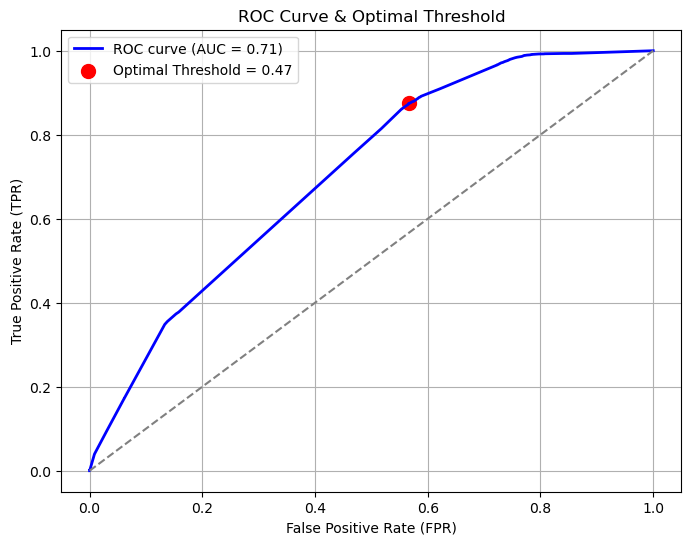

Optimal Threshold: 0.47

==== Test Set (Optimal Threshold) Metrics ====
AUC: 0.7085
F1 Score: 0.0554
Accuracy: 0.4418
Balanced Accuracy: 0.6542
Precision: 0.0286
Recall: 0.8748
Confusion Matrix:
[[255511 333826]
 [  1407   9828]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.43      0.60    589337
           1       0.03      0.87      0.06     11235

    accuracy                           0.44    600572
   macro avg       0.51      0.65      0.33    600572
weighted avg       0.98      0.44      0.59    600572



In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    roc_auc_score, f1_score, accuracy_score, balanced_accuracy_score, 
    precision_score, recall_score, confusion_matrix, classification_report,  roc_curve, auc
)

# **1️⃣ Test Setini Okuyalım**
parquet_path = "../../../tt_data/train_data.parquet"
df = pd.read_parquet(parquet_path)

# **2️⃣ ID ve Hedef Değişkeni Ayıralım**
if "id" in df.columns:
    df.drop(columns=["id"], inplace=True)

if "churn" not in df.columns:
    raise ValueError("Hedef değişken 'churn' bulunamadı!")

X = df.drop(columns=["churn"])
y = df["churn"]

# **3️⃣ Veriyi %80-%20 Stratify Ederek Bölelim**
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# **4️⃣ Eğitim Setindeki Sınıf Dağılımını Hesaplayalım**
total_samples = len(y_train)
class_0_count = (y_train == 0).sum()
class_1_count = (y_train == 1).sum()


print("\n=== Uygulanan Oransal Class Weights ===")
print(weights)

# **6️⃣ Min-Max Scaling**
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# **7️⃣ Decision Tree Modeli ile Eğitim**
model = DecisionTreeClassifier(
    random_state=42, 
    class_weight="balanced",
    max_depth=3)
model.fit(X_train_scaled, y_train)

# **8️⃣ Tahminleme**
train_probas = model.predict_proba(X_train_scaled)[:, 1]
test_probas = model.predict_proba(X_test_scaled)[:, 1]

threshold = 0.50
train_preds = (train_probas >= threshold).astype(int)
test_preds = (test_probas >= threshold).astype(int)

# **9️⃣ Metrikleri Hesaplayalım**
def evaluate_metrics(y_true, y_pred, probas, dataset_name):
    print(f"\n==== {dataset_name} Metrics ====")
    print(f"AUC: {roc_auc_score(y_true, probas):.4f}")
    print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("Classification Report:")
    print(classification_report(y_true, y_pred))

# **🔟 Sonuçları Yazdıralım**
evaluate_metrics(y_train, train_preds, train_probas, "Train Set")
evaluate_metrics(y_test, test_preds, test_probas, "Test Set")


# **🔹 ROC Eğrisi Hesaplama**
fpr, tpr, thresholds = roc_curve(y_test, test_probas)
roc_auc = auc(fpr, tpr)

# **🔹 Optimal Threshold'ü Belirleme (Youden’s J Statistic)**
optimal_idx = np.argmax(tpr - fpr)  # (TPR - FPR) farkı en büyük olan nokta
optimal_threshold = thresholds[optimal_idx]

# **🔹 ROC Eğrisini Çiz**
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color="red", s=100, label=f"Optimal Threshold = {optimal_threshold:.2f}")

# **Diagonal Çizgi (Rastgele Model Performansı)**
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")

# **Eksenler ve Başlık**
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve & Optimal Threshold")
plt.legend()
plt.grid()

# **Grafiği Göster**
plt.show()

print(f"Optimal Threshold: {optimal_threshold:.2f}")

# **🔹 Yeni Threshold ile Yeniden Tahminleme ve Performans Ölçme**
test_preds_optimal = (test_probas >= optimal_threshold).astype(int)
evaluate_metrics(y_test, test_preds_optimal, test_probas, "Test Set (Optimal Threshold)")


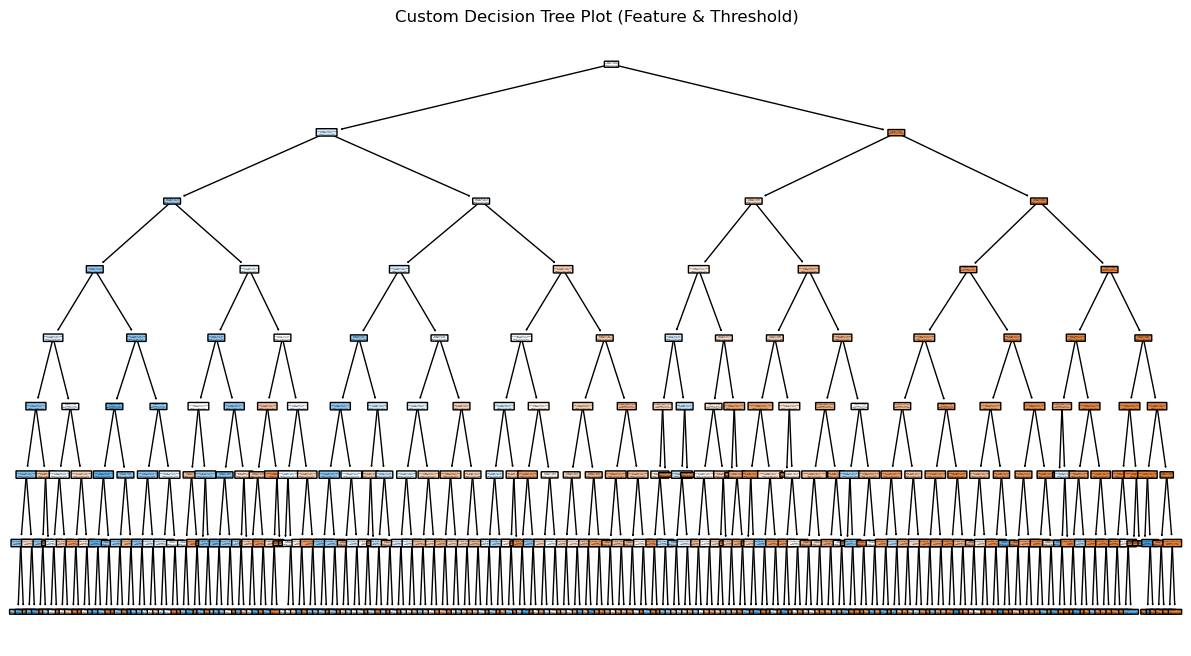

In [16]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# **1️⃣ Decision Tree Modelini Görselleştir**
plt.figure(figsize=(15, 8))

# **Custom Plot: Sadece Değişken İsimleri ve Eşik Değerleri**
plot_tree(
    model, 
    feature_names=X.columns,  # Değişken isimlerini ekle
    class_names=["No Churn", "Churn"],  # Sınıf isimleri
    filled=True,  # Düğümleri renklendir
    rounded=True,  # Düğümleri yuvarlatılmış yap
    impurity=False,  # Gini / Entropy değerlerini gösterme
    proportion=True  # Sınıfların oranlarını göster
)

# **Grafiği Göster**
plt.title("Custom Decision Tree Plot (Feature & Threshold)")
plt.show()


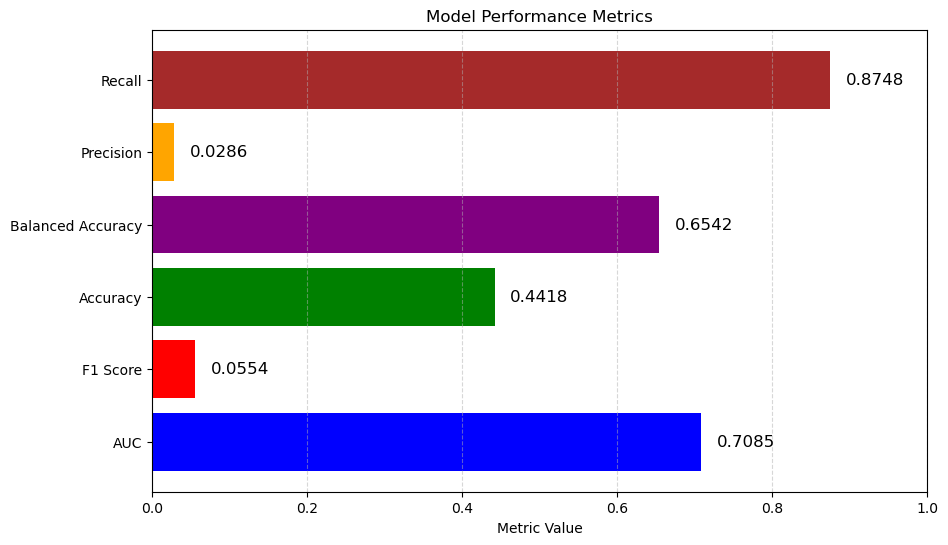

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# **🔹 Metrikleri Hesapla**
metrics_names = ["AUC", "F1 Score", "Accuracy", "Balanced Accuracy", "Precision", "Recall"]
metrics_values = [
    roc_auc_score(y_test, test_probas),
    f1_score(y_test, test_preds_optimal),
    accuracy_score(y_test, test_preds_optimal),
    balanced_accuracy_score(y_test, test_preds_optimal),
    precision_score(y_test, test_preds_optimal),
    recall_score(y_test, test_preds_optimal)
]

# **🔹 Bar Plot Çizimi**
plt.figure(figsize=(10, 6))
plt.barh(metrics_names, metrics_values, color=["blue", "red", "green", "purple", "orange", "brown"])

# **🔹 Değerleri Çubukların Üzerine Yazdır**
for index, value in enumerate(metrics_values):
    plt.text(value + 0.02, index, f"{value:.4f}", va="center", fontsize=12)

# **🔹 Eksen Etiketleri ve Başlık**
plt.xlabel("Metric Value")
plt.title("Model Performance Metrics")
plt.xlim(0, 1)  # Metrikler 0-1 arasında olduğu için x eksenini sınırla
plt.grid(axis="x", linestyle="--", alpha=0.5)

# **🔹 Grafiği Göster**
plt.show()


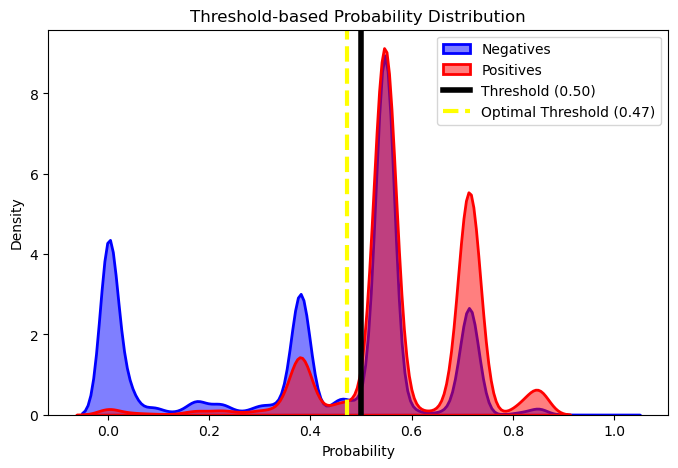

In [14]:
# **🔹 Density Plot (Threshold'ü Görselleştirme)**
plt.figure(figsize=(8, 5))

# Negatif (Gerçek 0) ve Pozitif (Gerçek 1) olanları ayıralım
neg_probs = test_probas[y_test == 0]
pos_probs = test_probas[y_test == 1]

# KDE Plot Çizimi
sns.kdeplot(neg_probs, color="blue", fill=True, alpha=0.5, linewidth=2, label="Negatives")
sns.kdeplot(pos_probs, color="red", fill=True, alpha=0.5, linewidth=2, label="Positives")

# Threshold Çizgisi
plt.axvline(x=threshold, color="black", linestyle="-", linewidth=4, label=f"Threshold (0.50)")
plt.axvline(x=optimal_threshold, color="yellow", linestyle="--", linewidth=3, label=f"Optimal Threshold ({optimal_threshold:.2f})")

# Eksenler ve Legend
plt.xlabel("Probability")
plt.ylabel("Density")
plt.title("Threshold-based Probability Distribution")
plt.legend()

# Grafiği Göster
plt.show()


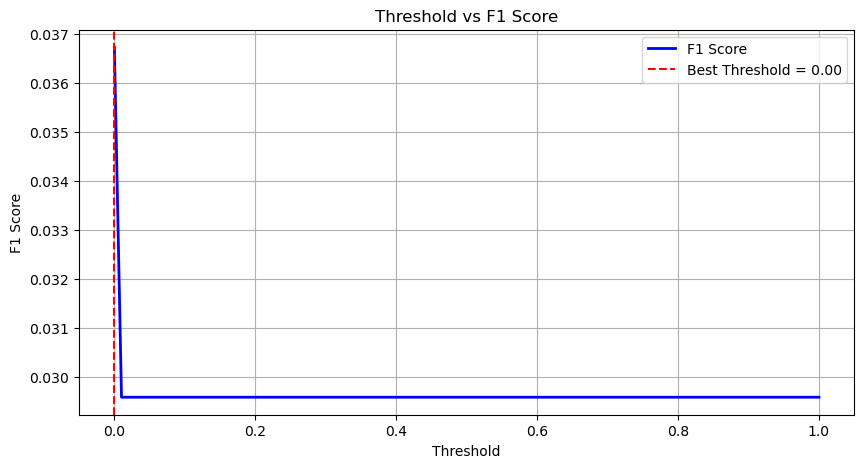

Best Threshold: 0.0000, Best F1 Score: 0.0367


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# Eşik değerlerini belirleyelim
thresholds = np.linspace(0, 1, 100)

# F1 skorlarını hesaplayalım
f1_scores = [f1_score(y_test, (test_probas >= t).astype(int)) for t in thresholds]

# Optimal Threshold'u belirleyelim
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)

# Threshold Curve'i çizelim
plt.figure(figsize=(10, 5))
plt.plot(thresholds, f1_scores, label="F1 Score", color="blue", linewidth=2)
plt.axvline(x=best_threshold, color="red", linestyle="--", label=f"Best Threshold = {best_threshold:.2f}")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("Threshold vs F1 Score")
plt.legend()
plt.grid()
plt.show()

print(f"Best Threshold: {best_threshold:.4f}, Best F1 Score: {best_f1:.4f}")


In [6]:
X.head()

,age,avg_call_duration,avg_top_up_count,call_drops,customer_support_calls,data_usage,monthly_charge,overdue_payments,roaming_usage,satisfaction_score,tenure,RitimGo,Konuşalım,other_apps_used
0,20,65.89,37,18,20,95.19,679.31,0,18.86,4.98,67,0,0,0
1,18,14.62,46,0,2,23.99,196.61,0,20.11,4.03,24,1,0,0
2,24,30.76,14,0,18,149.94,2308.01,0,13.76,5.04,252,0,0,0
3,28,31.57,15,14,8,197.64,1938.62,0,47.92,4.52,255,0,1,0
4,18,48.54,94,18,17,177.03,1800.44,0,8.57,2.22,267,0,0,0



=== Orijinal Veri Setindeki Sınıf Dağılımı ===
0    0.981292
1    0.018708
Name: churn, dtype: float64

=== Eğitim ve Test Setindeki Sınıf Dağılımı ===
Eğitim Seti:
0    0.981292
1    0.018708
Name: churn, dtype: float64
Test Seti:
0    0.981293
1    0.018707
Name: churn, dtype: float64

=== Modelin Class Weight Hesaplaması ===
Ağırlıklar: {0: 0.01870785055698623, 1: 0.9812921494430138}

=== Modelin Tahmin Sonuçlarındaki Sınıf Dağılımı ===
Eğitim Seti Tahminleri:
0    0.981292
1    0.018708
dtype: float64
Test Seti Tahminleri:
0    0.981003
1    0.018997
dtype: float64

=== Confusion Matrix (Eğitim Seti) ===
[[2357343       0]
 [      0   44942]]

=== Confusion Matrix (Test Seti) ===
[[578263  11074]
 [ 10900    335]]

=== Ağırlıksız Model Confusion Matrix (Test Seti) ===
[[589337      0]
 [ 11235      0]]


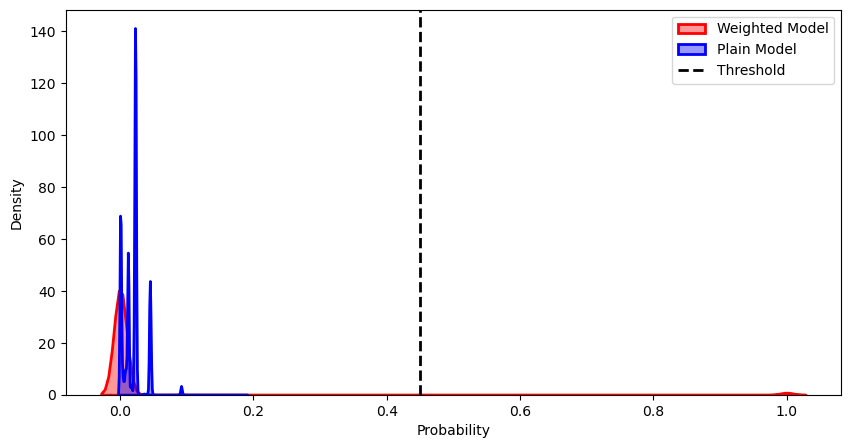

In [7]:
# **1️⃣ Orijinal Veri Setindeki Sınıf Dağılımı**
print("\n=== Orijinal Veri Setindeki Sınıf Dağılımı ===")
print(y.value_counts(normalize=True))

# **2️⃣ Eğitim ve Test Setindeki Sınıf Dağılımı**
print("\n=== Eğitim ve Test Setindeki Sınıf Dağılımı ===")
print("Eğitim Seti:")
print(y_train.value_counts(normalize=True))
print("Test Seti:")
print(y_test.value_counts(normalize=True))

# **3️⃣ Modelin Uyguladığı Ağırlıkları Kontrol Edelim**
print("\n=== Modelin Class Weight Hesaplaması ===")
print("Ağırlıklar:", weights)

# **4️⃣ Tahmin Sonuçlarındaki Sınıf Dağılımını Kontrol Edelim**
print("\n=== Modelin Tahmin Sonuçlarındaki Sınıf Dağılımı ===")
print("Eğitim Seti Tahminleri:")
print(pd.Series(train_preds).value_counts(normalize=True))
print("Test Seti Tahminleri:")
print(pd.Series(test_preds).value_counts(normalize=True))

# **5️⃣ Confusion Matrix ile Modelin Ne Kadar Denge Sağladığını Görelim**
print("\n=== Confusion Matrix (Eğitim Seti) ===")
print(confusion_matrix(y_train, train_preds))

print("\n=== Confusion Matrix (Test Seti) ===")
print(confusion_matrix(y_test, test_preds))

# **6️⃣ Ağırlıklı Model ile Ağırlıksız Modeli Karşılaştırma**
# Ağırlıksız Model Kur
plain_model = DecisionTreeClassifier(random_state=42, max_depth=6, min_samples_split=8, min_samples_leaf=10)
plain_model.fit(X_train_scaled, y_train)

plain_test_probas = plain_model.predict_proba(X_test_scaled)[:, 1]
plain_test_preds = (plain_test_probas >= threshold).astype(int)

print("\n=== Ağırlıksız Model Confusion Matrix (Test Seti) ===")
print(confusion_matrix(y_test, plain_test_preds))

# **7️⃣ Ağırlıklı vs Ağırlıksız Modelin Tahmin Dağılımı**
plt.figure(figsize=(10, 5))
sns.kdeplot(test_probas, color="red", fill=True, alpha=0.4, linewidth=2, label="Weighted Model")
sns.kdeplot(plain_test_probas, color="blue", fill=True, alpha=0.4, linewidth=2, label="Plain Model")

plt.axvline(x=threshold, color="black", linestyle="--", linewidth=2, label="Threshold")

plt.xlabel("Probability")
plt.ylabel("Density")
plt.legend()
plt.show()
